<a href="https://colab.research.google.com/github/dejo32/youtubeanalyzer/blob/main/YoutubeAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


YouTube API initialized
🤖 Sentiment model loaded
📺 Fetching data for channel: UCX6OQ3DkcsbYNE6H8uQQuVA
🔍 Found playlist: UUX6OQ3DkcsbYNE6H8uQQuVA
⚠️ Limiting to first 50 videos
📹 Found 50 videos. Fetching details...
💬 Video 1: Analyzed 10 comments
💬 Video 2: Analyzed 10 comments
💬 Video 3: Analyzed 10 comments
💬 Video 4: Analyzed 10 comments
💬 Video 5: Analyzed 10 comments
💬 Video 6: Analyzed 10 comments
💬 Video 7: Analyzed 10 comments
💬 Video 8: Analyzed 10 comments
💬 Video 9: Analyzed 10 comments
💬 Video 10: Analyzed 10 comments
✅ Successfully fetched 50 videos
🔍 Performing content analysis...
✅ Identified 5 content topics

🔑 Content Topics Identified:
• Topic 0: Person One Vacation
• Topic 1: Win Last Subscribe
• Topic 2: Happy birthday Birthday Last leave
• Topic 3: Penguin Tseries subscribe Got tseries
• Topic 4: Nolan Neymar Win obstacle

📊 Sample data:


<ipython-input-6-683895674>:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_content['dominant_topic'] = np.argmax(topic_distributions, axis=1)
<ipython-input-6-683895674>:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_content['topic_name'] = valid_content['dominant_topic'].map(topic_name_map)


,title,views,engagement_rate,topic_name
0,Feastables vs Reese’s Taste Test with @gordonr...,129567273,2.275224,Person One Vacation
1,"$1 vs $500,000 Romantic Date",74953232,3.389095,Nolan Neymar Win obstacle
2,Gordon Ramsay Decides Feastables vs Hershey’s,27869520,3.231577,Nolan Neymar Win obstacle
3,Can I Teach a Penguin To Subscribe?,113757703,2.417216,Penguin Tseries subscribe Got tseries
4,Extreme Helmet Game,117795679,2.127471,Nolan Neymar Win obstacle



📈 Visualizations:


<ipython-input-6-683895674>:515: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='views', y='short_title', data=top_videos, palette='viridis')


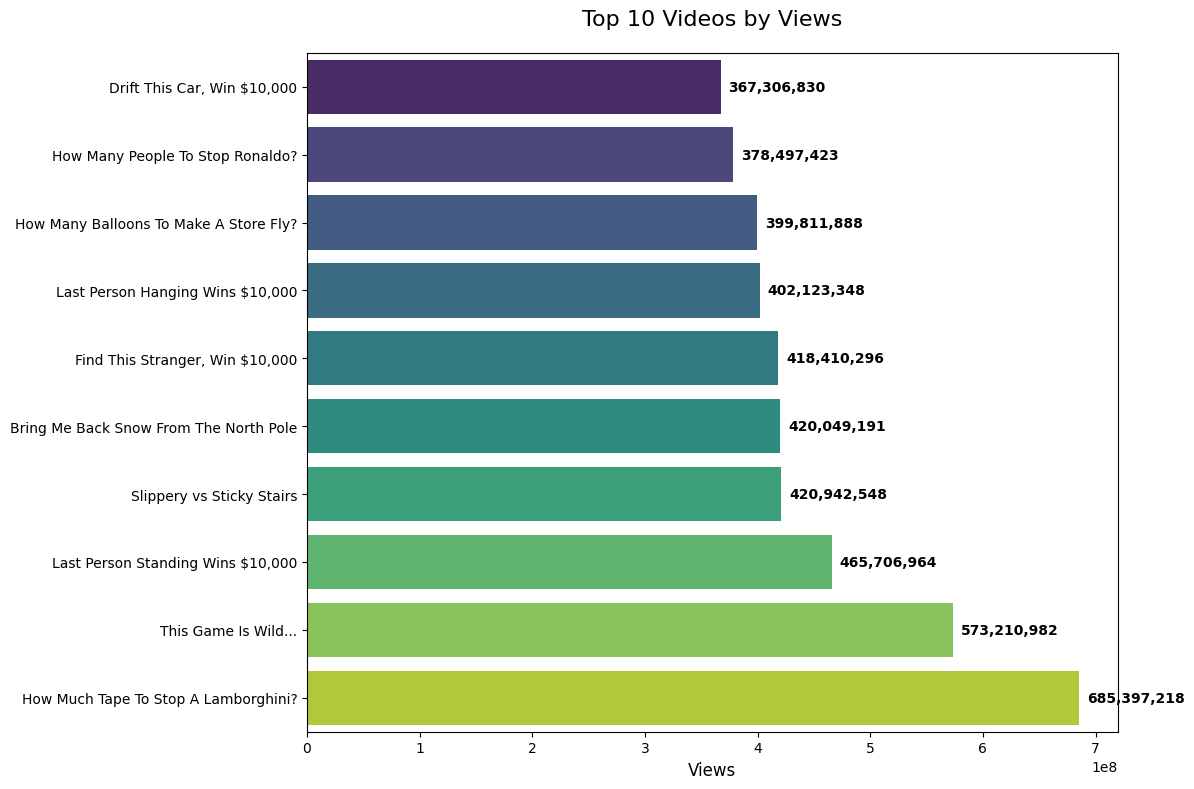

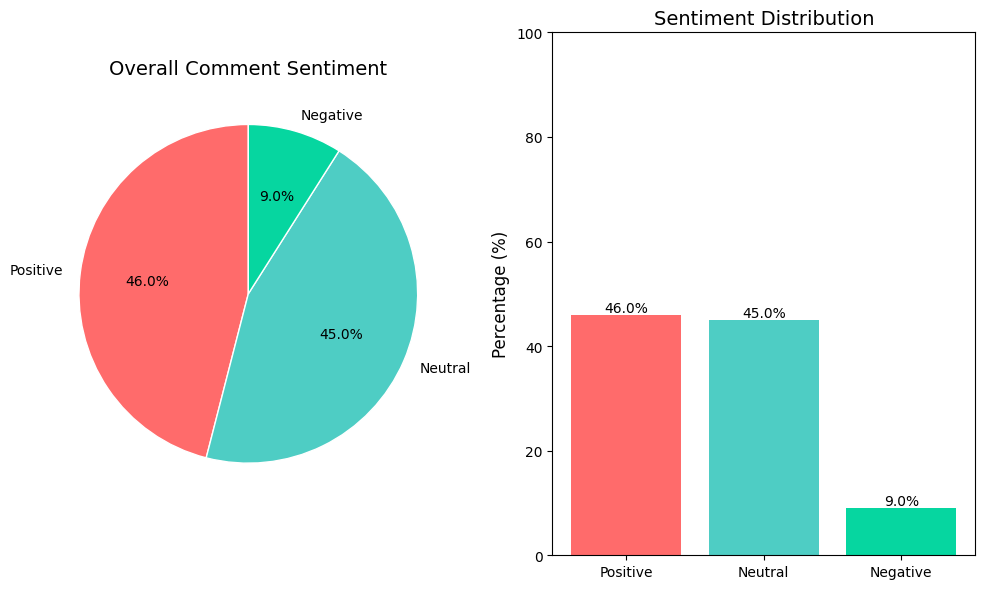

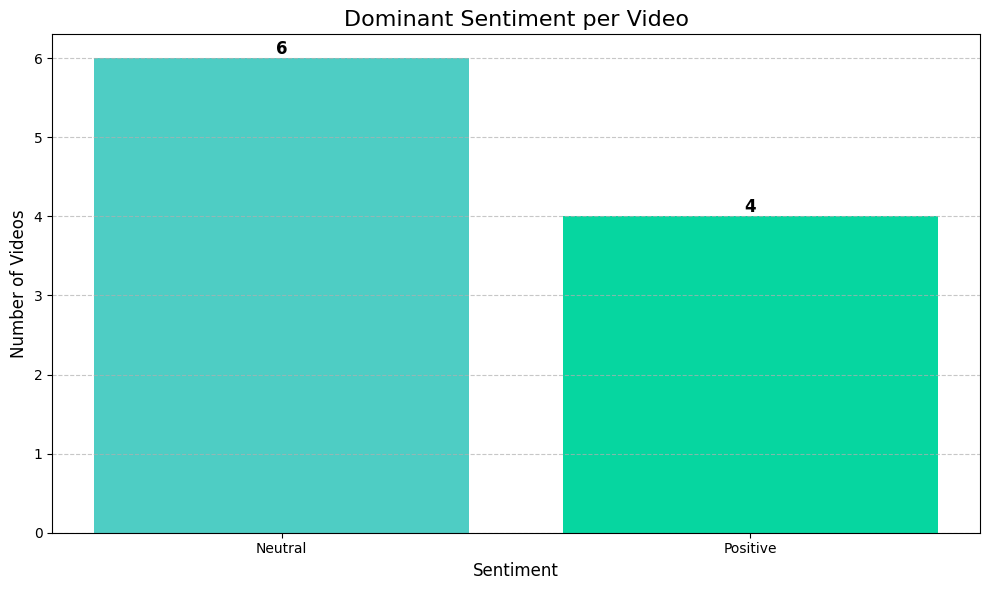

<ipython-input-6-683895674>:321: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(y='topic_name', x='avg_views', data=topic_performance, palette='viridis')
<ipython-input-6-683895674>:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(y='topic_name', x='avg_engagement', data=topic_performance, palette='magma')
<ipython-input-6-683895674>:350: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(y='topic_name', x='video_count', data=topic_performance, palette='plasma')


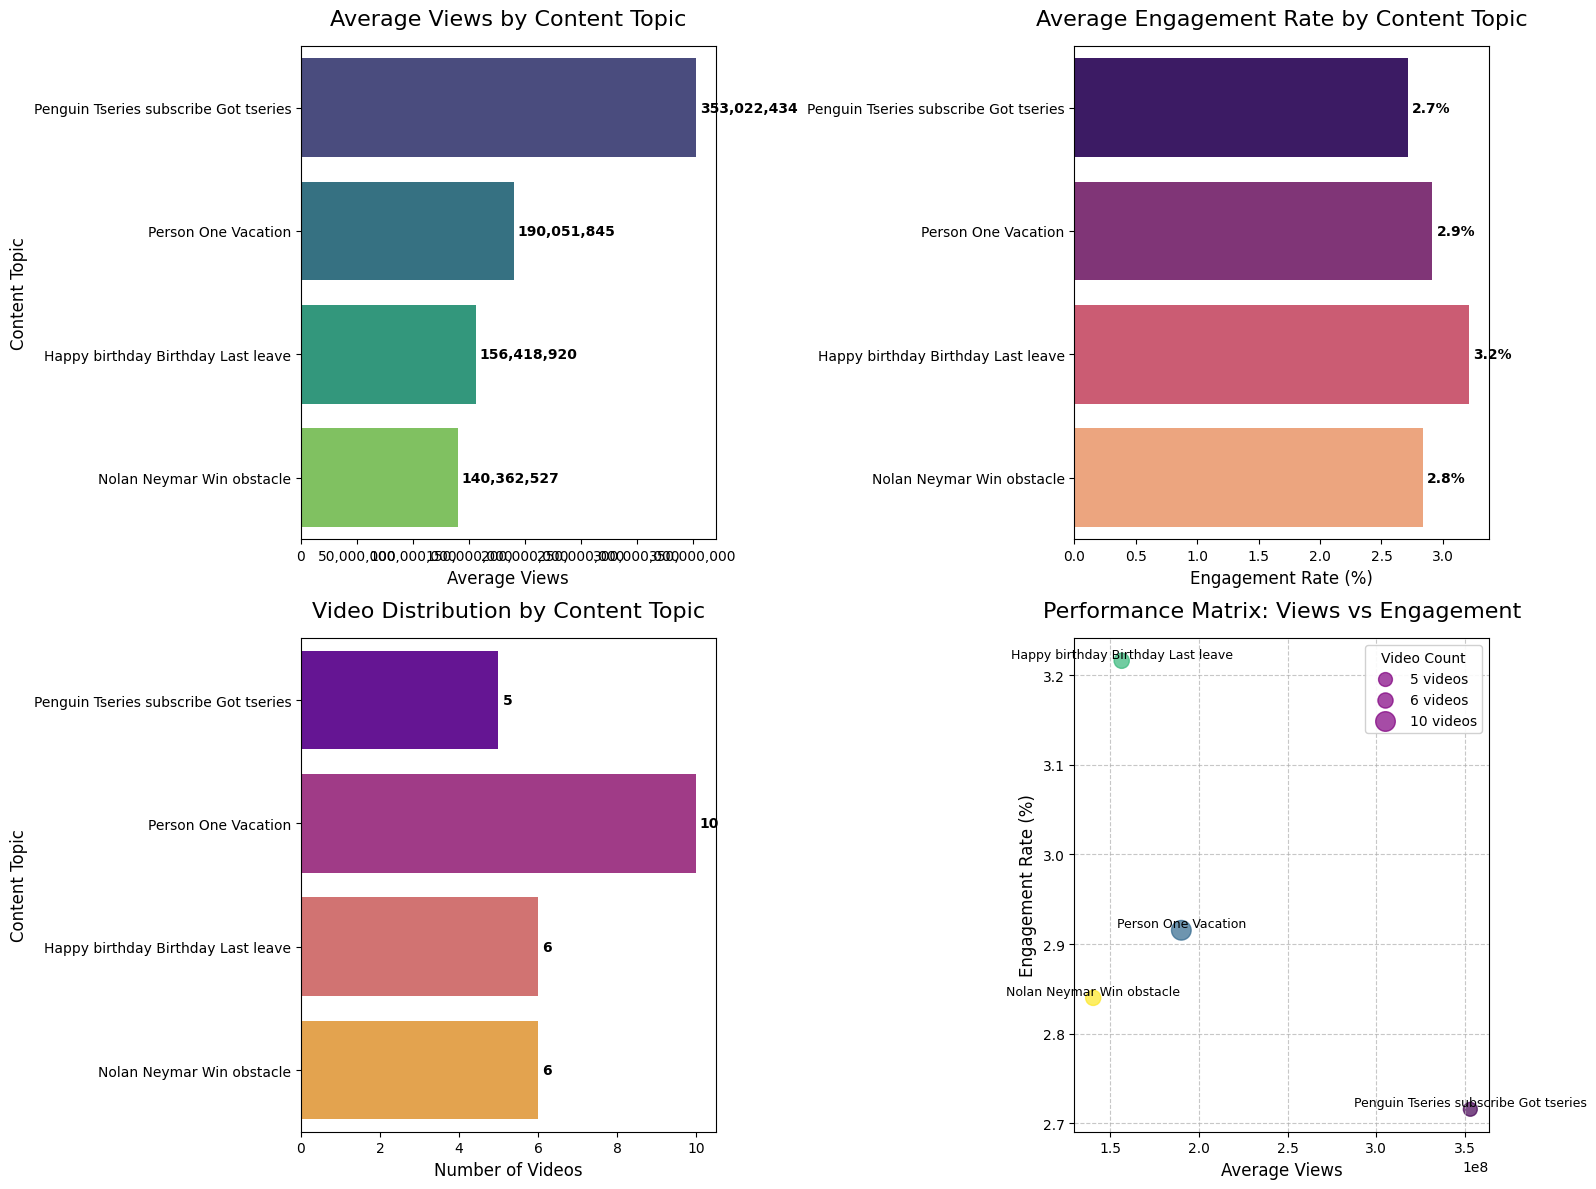

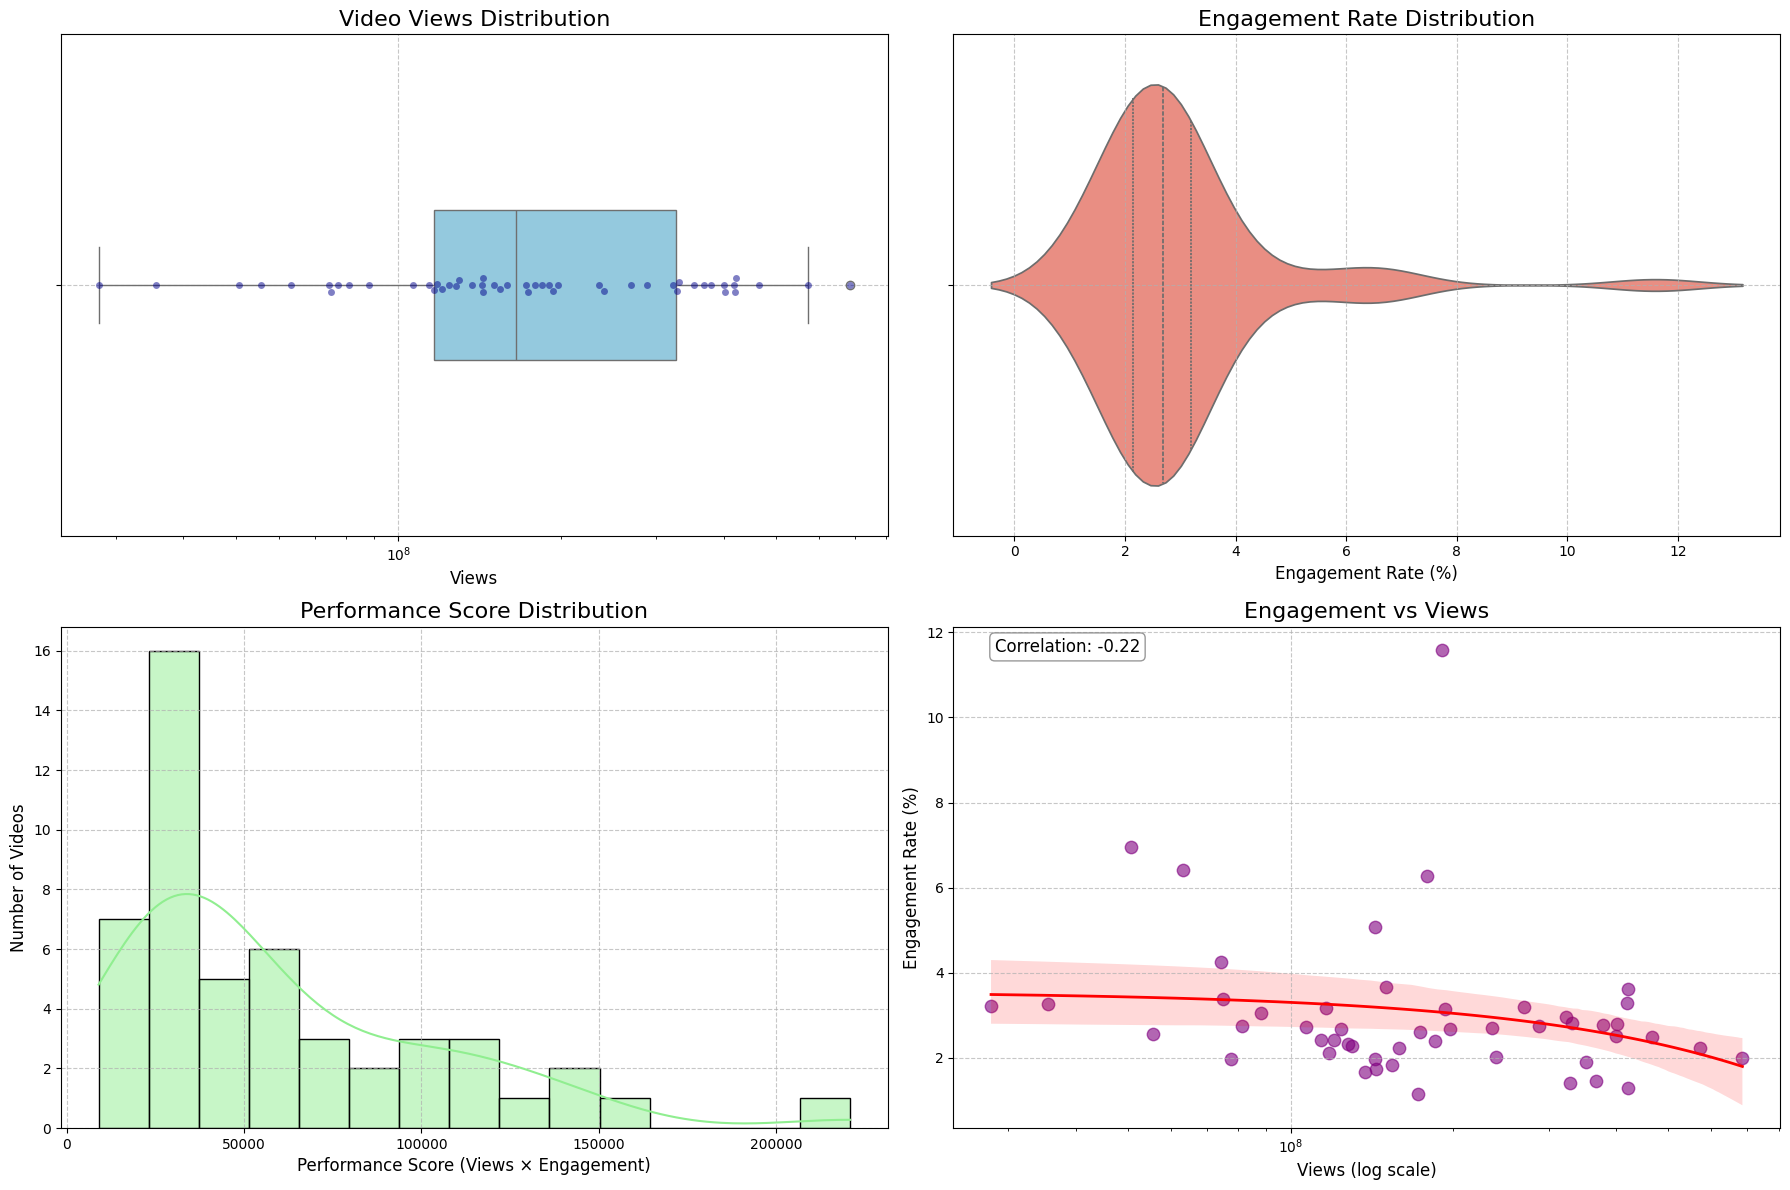


💾 Results saved to 'youtube_channel_analysis.csv'


In [6]:
# Import libraries
from googleapiclient.discovery import build
import pandas as pd
from google.colab import userdata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import re
from googleapiclient.errors import HttpError
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize YouTube API
YOUTUBE_API_KEY = userdata.get('YoutubeDataAPI')
youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
print("YouTube API initialized")

# Load sentiment analysis model globally
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
print("🤖 Sentiment model loaded")

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Utility functions
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def preprocess_text(text):
    """Preprocess text for content analysis"""
    if not isinstance(text, str):
        return ""

    # Lowercase, remove punctuation/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return " ".join(tokens)

def create_topic_name(keywords):
    """Create a readable topic name from keywords"""
    # Take the first 3 keywords and capitalize them
    main_words = [word.capitalize() for word in keywords.split(", ")[:3]]
    return " ".join(main_words)

# Function to fetch comments
def get_top_comments(video_id, max_results=10):
    """Fetch top comments for a video"""
    comments = []
    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=max_results,
            order="relevance"
        )
        response = request.execute()
        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)
    except HttpError as e:
        if "commentsDisabled" in str(e):
            pass  # Silently skip comments-disabled videos
        else:
            print(f"⚠️ Error fetching comments for {video_id}: {e}")
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
    return comments

# Sentiment analysis for text
def analyze_text_sentiment(texts):
    """Analyze sentiment for a list of texts"""
    if not texts:
        return [], []

    sentiments = []
    confidences = []
    batch_size = 32

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )
        outputs = model(**inputs)
        logits = outputs.logits.detach().numpy()
        probs = softmax(logits, axis=1)

        for prob in probs:
            label_idx = np.argmax(prob)
            sentiments.append(['Negative', 'Neutral', 'Positive'][label_idx])
            confidences.append(prob[label_idx])  # Store confidence score

    return sentiments, confidences

# Main function to get video data
def get_video_data(channel_id, max_videos=100):
    """Fetch video data from YouTube channel"""
    print(f"📺 Fetching data for channel: {channel_id}")
    try:
        # Get channel's uploads playlist
        request = youtube.channels().list(part='contentDetails', id=channel_id)
        response = request.execute()
        playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        print(f"🔍 Found playlist: {playlist_id}")
    except Exception as e:
        print(f"❌ Error getting channel data: {e}")
        return pd.DataFrame()

    # Fetch video IDs
    video_ids = []
    next_page_token = None
    try:
        while True:
            pl_request = youtube.playlistItems().list(
                part='snippet',
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token
            )
            pl_response = pl_request.execute()
            new_ids = [item['snippet']['resourceId']['videoId'] for item in pl_response['items']]
            video_ids.extend(new_ids)

            # Limit to max_videos for quota management
            if len(video_ids) >= max_videos:
                video_ids = video_ids[:max_videos]
                print(f"⚠️ Limiting to first {max_videos} videos")
                break

            next_page_token = pl_response.get('nextPageToken')
            if not next_page_token:
                break
    except Exception as e:
        print(f"❌ Error fetching playlist items: {e}")

    if not video_ids:
        print("❌ No videos found for this channel.")
        return pd.DataFrame()

    print(f"📹 Found {len(video_ids)} videos. Fetching details...")

    # Fetch video details in batches
    video_data = []
    for chunk in chunks(video_ids, 50):
        try:
            video_request = youtube.videos().list(
                part='snippet,statistics,contentDetails',
                id=','.join(chunk))
            video_response = video_request.execute()
            video_data.extend(video_response['items'])
            time.sleep(1)  # Avoid quota errors
        except Exception as e:
            print(f"❌ Error fetching video details: {e}")

    # Process video data
    data = []
    for i, video in enumerate(video_data):
        try:
            video_id = video['id']

            # Get top comments for first 10 videos only
            comments = get_top_comments(video_id) if i < 10 else []
            comment_sentiments = []
            sentiment_confidences = []
            dominant_sentiment = None

            # Analyze comment sentiments if comments exist
            if comments:
                comment_sentiments, sentiment_confidences = analyze_text_sentiment(comments)
                print(f"💬 Video {i+1}: Analyzed {len(comments)} comments")

                # Get dominant sentiment with confidence
                if comment_sentiments:
                    counter = Counter(comment_sentiments)
                    dominant_sentiment = counter.most_common(1)[0][0]

            # Calculate performance metrics
            views = int(video['statistics'].get('viewCount', 0))
            likes = int(video['statistics'].get('likeCount', 0))
            dislikes = int(video['statistics'].get('dislikeCount', 0))
            comment_count = int(video['statistics'].get('commentCount', 0))

            # Calculate engagement metrics
            engagement_rate = (likes + dislikes + comment_count) / views * 100 if views > 0 else 0
            like_ratio = likes / (likes + dislikes) * 100 if (likes + dislikes) > 0 else 0

            # Determine video type (short or long)
            duration = video['contentDetails']['duration']
            is_short = True if "M" not in duration and "S" in duration and int(duration[2:-1]) < 60 else False

            data.append({
                'video_id': video_id,
                'title': video['snippet']['title'],
                'published_at': video['snippet']['publishedAt'],
                'views': views,
                'likes': likes,
                'dislikes': dislikes,
                'comments': comment_count,
                'duration': duration,
                'is_short': is_short,
                'engagement_rate': engagement_rate,
                'like_ratio': like_ratio,
                'top_comments': comments,
                'comment_sentiments': comment_sentiments,  # For visualization only
                'dominant_comment_sentiment': dominant_sentiment
            })
        except Exception as e:
            print(f"❌ Error processing video {video_id}: {e}")

    df = pd.DataFrame(data) if data else pd.DataFrame()

    if not df.empty:
        # Add title sentiments
        title_sentiments, _ = analyze_text_sentiment(df['title'].tolist())
        df['title_sentiment'] = title_sentiments

        # Preprocess content for topic modeling
        df['processed_content'] = (df['title'] + " " +
                                   df['top_comments'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")).apply(preprocess_text)

    print(f"✅ Successfully fetched {len(df)} videos")
    return df

# Content analysis functions
def perform_content_analysis(df):
    """Perform topic modeling on video content"""
    if df.empty or 'processed_content' not in df.columns:
        print("❌ No content available for analysis")
        return df, []

    # Filter out empty content
    valid_content = df[df['processed_content'].str.len() > 20]
    if len(valid_content) < 5:
        print("⚠️ Insufficient content for topic modeling")
        return df, []

    print("🔍 Performing content analysis...")

    # Vectorize content
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
    content_vectors = vectorizer.fit_transform(valid_content['processed_content'])

    # Topic modeling
    n_topics = min(5, len(valid_content) - 1)  # Ensure we have at least 1 document per topic
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_distributions = lda.fit_transform(content_vectors)

    # Get dominant topic for each video
    valid_content['dominant_topic'] = np.argmax(topic_distributions, axis=1)

    # Get topic keywords
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = []
    topic_names = []
    for topic_idx, topic in enumerate(lda.components_):
        top_features = topic.argsort()[:-11:-1]
        keywords = ", ".join([feature_names[i] for i in top_features])
        topic_keywords.append(keywords)
        topic_names.append(create_topic_name(keywords))

    # Map topic names to videos
    topic_name_map = {i: topic_names[i] for i in range(n_topics)}
    valid_content['topic_name'] = valid_content['dominant_topic'].map(topic_name_map)

    # Merge results back to main dataframe
    df = df.merge(valid_content[['video_id', 'dominant_topic', 'topic_name']],
                 on='video_id', how='left')

    print(f"✅ Identified {n_topics} content topics")
    return df, topic_names

def plot_content_performance(df):
    """Plot performance metrics by content topic"""
    if 'topic_name' not in df.columns or df['topic_name'].isnull().all():
        print("❌ No topic data available")
        return

    # Aggregate metrics by topic
    topic_performance = df.groupby('topic_name').agg(
        avg_views=('views', 'mean'),
        avg_engagement=('engagement_rate', 'mean'),
        video_count=('video_id', 'count')
    ).reset_index()

    if topic_performance.empty:
        return

    # Sort by views for better visualization
    topic_performance = topic_performance.sort_values('avg_views', ascending=False)

    # Plot performance
    plt.figure(figsize=(16, 12))

    # Views by topic - Horizontal bar chart
    plt.subplot(2, 2, 1)
    ax1 = sns.barplot(y='topic_name', x='avg_views', data=topic_performance, palette='viridis')
    plt.title('Average Views by Content Topic', fontsize=16, pad=15)
    plt.xlabel('Average Views', fontsize=12)
    plt.ylabel('Content Topic', fontsize=12)

    # Format x-axis with thousands separator
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Add value labels
    for i, v in enumerate(topic_performance['avg_views']):
        ax1.text(v + max(topic_performance['avg_views'])*0.01, i,
                f"{v:,.0f}",
                color='black', va='center', fontweight='bold')

    # Engagement by topic - Horizontal bar chart
    plt.subplot(2, 2, 2)
    ax2 = sns.barplot(y='topic_name', x='avg_engagement', data=topic_performance, palette='magma')
    plt.title('Average Engagement Rate by Content Topic', fontsize=16, pad=15)
    plt.xlabel('Engagement Rate (%)', fontsize=12)
    plt.ylabel('')

    # Add value labels
    for i, v in enumerate(topic_performance['avg_engagement']):
        ax2.text(v + max(topic_performance['avg_engagement'])*0.01, i,
                f"{v:.1f}%",
                color='black', va='center', fontweight='bold')

    # Video distribution by topic - Horizontal bar chart
    plt.subplot(2, 2, 3)
    ax3 = sns.barplot(y='topic_name', x='video_count', data=topic_performance, palette='plasma')
    plt.title('Video Distribution by Content Topic', fontsize=16, pad=15)
    plt.xlabel('Number of Videos', fontsize=12)
    plt.ylabel('Content Topic', fontsize=12)

    # Add value labels
    for i, v in enumerate(topic_performance['video_count']):
        ax3.text(v + max(topic_performance['video_count'])*0.01, i,
                f"{v}",
                color='black', va='center', fontweight='bold')

    # Performance matrix - Bubble chart
    plt.subplot(2, 2, 4)
    sizes = topic_performance['video_count'] * 20  # Scale for visibility
    scatter = plt.scatter(
        x=topic_performance['avg_views'],
        y=topic_performance['avg_engagement'],
        s=sizes,
        c=np.arange(len(topic_performance)),
        cmap='viridis',
        alpha=0.7
    )

    # Add labels for each topic
    for i, row in topic_performance.iterrows():
        plt.text(row['avg_views'], row['avg_engagement'], row['topic_name'],
                 fontsize=9, ha='center', va='bottom')

    plt.title('Performance Matrix: Views vs Engagement', fontsize=16, pad=15)
    plt.xlabel('Average Views', fontsize=12)
    plt.ylabel('Engagement Rate (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # FIXED: Create custom legend for bubble sizes
    if not topic_performance.empty:
        # Get representative sizes (min, max, median)
        size_values = sorted(set(topic_performance['video_count']))
        if size_values:
            rep_sizes = [
                size_values[0],
                size_values[len(size_values)//2] if len(size_values) > 1 else size_values[0],
                size_values[-1]
            ]
        else:
            rep_sizes = [1, 2, 3]  # Fallback values

        # Create legend handles
        handles = [
            plt.scatter([], [], s=s*20, color='purple', alpha=0.7)
            for s in rep_sizes
        ]
        plt.legend(
            handles,
            [f"{int(s)} videos" for s in rep_sizes],
            title="Video Count",
            loc='upper right',
            frameon=True,
            framealpha=0.9
        )

    plt.tight_layout()
    plt.show()

# Visualization functions
def plot_comment_sentiment_distribution(df):
    """Plot sentiment distribution of all comments"""
    # Collect all comment sentiments
    all_sentiments = []
    for sentiments in df['comment_sentiments']:
        all_sentiments.extend(sentiments)

    if not all_sentiments:
        print("❌ No comment sentiment data available")
        return

    # Calculate percentages
    sentiment_counts = pd.Series(all_sentiments).value_counts()
    total = sentiment_counts.sum()
    percentages = (sentiment_counts / total) * 100

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#06D6A0']  # Red, Teal, Green

    # Pie chart
    plt.subplot(1, 2, 1)
    plt.pie(percentages,
            labels=percentages.index,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    plt.title('Overall Comment Sentiment', fontsize=14)

    # Bar chart
    plt.subplot(1, 2, 2)
    bars = plt.bar(percentages.index, percentages.values, color=colors)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title('Sentiment Distribution', fontsize=14)
    plt.ylim(0, 100)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_video_sentiment_summary(df):
    """Plot video-level sentiment summary"""
    if 'dominant_comment_sentiment' not in df.columns:
        print("❌ No dominant sentiment data available")
        return

    # Count videos by sentiment
    sentiment_counts = df['dominant_comment_sentiment'].value_counts()

    if sentiment_counts.empty:
        print("❌ No video sentiment data available")
        return

    # Plot
    plt.figure(figsize=(10, 6))
    colors = {'Negative': '#FF6B6B', 'Neutral': '#4ECDC4', 'Positive': '#06D6A0'}

    # Create bar plot
    bars = plt.bar(sentiment_counts.index, sentiment_counts.values,
                   color=[colors[s] for s in sentiment_counts.index])
    plt.title('Dominant Sentiment per Video', fontsize=16)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_top_videos(df):
    """Plot top 10 most viewed videos"""
    if df.empty:
        print("❌ No data available for top videos")
        return

    # Get top videos sorted by views (descending)
    top_videos = df.nlargest(10, 'views').copy()

    # Sort ascending for plot (highest at top)
    top_videos = top_videos.sort_values('views', ascending=True)

    # Truncate long titles
    top_videos['short_title'] = top_videos['title'].apply(
        lambda x: (x[:40] + '...') if len(x) > 40 else x
    )

    # Create plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='views', y='short_title', data=top_videos, palette='viridis')

    # Add view counts on bars
    for i, v in enumerate(top_videos['views']):
        ax.text(v + max(top_videos['views'])*0.01, i,
                f"{v:,}",
                color='black', va='center', fontweight='bold')

    plt.title('Top 10 Videos by Views', fontsize=16, pad=20)
    plt.xlabel('Views', fontsize=12)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

def plot_performance_metrics(df):
    """Plot various performance metrics with enhanced visualizations"""
    if df.empty:
        return

    # Calculate additional metrics
    df['performance_score'] = (df['views'] * df['engagement_rate']) / 10000

    # Create figure with subplots
    plt.figure(figsize=(18, 12))

    # Views distribution - Box plot with swarm
    plt.subplot(2, 2, 1)
    sns.boxplot(x=df['views'], color='skyblue', width=0.3)
    sns.swarmplot(x=df['views'], color='darkblue', alpha=0.5)
    plt.title('Video Views Distribution', fontsize=16)
    plt.xlabel('Views', fontsize=12)
    plt.xscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Engagement rate distribution - Violin plot
    plt.subplot(2, 2, 2)
    sns.violinplot(x=df['engagement_rate'], color='salmon', inner='quartile')
    plt.title('Engagement Rate Distribution', fontsize=16)
    plt.xlabel('Engagement Rate (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Performance score distribution - Histogram with KDE
    plt.subplot(2, 2, 3)
    sns.histplot(df['performance_score'], bins=15, kde=True, color='lightgreen')
    plt.title('Performance Score Distribution', fontsize=16)
    plt.xlabel('Performance Score (Views × Engagement)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Engagement vs Views - Scatter plot with regression
    plt.subplot(2, 2, 4)
    sns.regplot(
        x='views',
        y='engagement_rate',
        data=df,
        scatter_kws={'alpha':0.6, 's':80, 'color':'purple'},
        line_kws={'color':'red', 'linewidth':2}
    )
    plt.title('Engagement vs Views', fontsize=16)
    plt.xlabel('Views (log scale)', fontsize=12)
    plt.ylabel('Engagement Rate (%)', fontsize=12)
    plt.xscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add correlation coefficient
    corr_coef = np.corrcoef(df['views'], df['engagement_rate'])[0, 1]
    plt.annotate(f'Correlation: {corr_coef:.2f}',
                 xy=(0.05, 0.95),
                 xycoords='axes fraction',
                 fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()

# ======================
# MAIN EXECUTION
# ======================

# Choose a YouTube channel to analyze
CHANNEL_ID = "UCX6OQ3DkcsbYNE6H8uQQuVA"  # MrBeast channel

# Fetch video data
df = get_video_data(CHANNEL_ID, max_videos=50)  # Limit to 50 videos

if not df.empty:
    # Perform content analysis
    df, topic_names = perform_content_analysis(df)

    # Show topic names
    if topic_names:
        print("\n🔑 Content Topics Identified:")
        for i, name in enumerate(topic_names):
            print(f"• Topic {i}: {name}")

    # Show sample data
    print("\n📊 Sample data:")
    display(df[['title', 'views', 'engagement_rate', 'topic_name']].head())

    # Create visualizations
    print("\n📈 Visualizations:")
    plot_top_videos(df)
    plot_comment_sentiment_distribution(df)
    plot_video_sentiment_summary(df)

    # Only plot content performance if topics were identified
    if 'topic_name' in df.columns and not df['topic_name'].isnull().all():
        plot_content_performance(df)

    plot_performance_metrics(df)

    # Clean up before saving (remove detailed sentiments and processed content)
    try:
        df_clean = df.drop(columns=['comment_sentiments', 'processed_content'], errors='ignore')
        df_clean.to_csv('youtube_channel_analysis.csv', index=False)
        print("\n💾 Results saved to 'youtube_channel_analysis.csv'")
    except Exception as e:
        print(f"\n❌ Error saving results: {e}")
        print("💡 Trying alternative saving method...")
        try:
            df_clean.to_csv('youtube_backup.csv', index=False)
            print("✅ Backup save successful")
        except:
            print("❌ Critical error: Failed to save data")
else:
    print("❌ No data available for analysis")